In [1]:
import numpy as np
from numpy.random import default_rng 
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_classification
from typing import TypedDict

rng = default_rng(42)

In [2]:
X_orig, y_orig = make_moons(400, noise=0.25)
print(X_orig.shape)
print(y_orig.shape)

(400, 2)
(400,)


In [3]:
X, Y = X_orig.T, y_orig.reshape(1, 400)
m, n = X.shape[1], X.shape[0]
print(X.shape)
print(Y.shape)

(2, 400)
(1, 400)


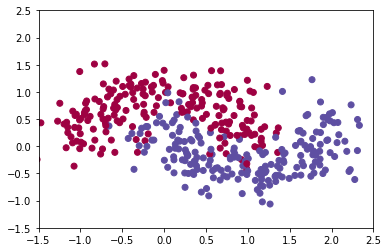

In [4]:
plt.scatter(X[0, :], X[1, :], c=Y, cmap=plt.cm.Spectral)
plt.axis([-1.5, 2.5, -1.5, 2.5])
plt.show()

In [5]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

log_reg = LogisticRegressionCV()
log_reg.fit(X.T, Y.flat)

LogisticRegressionCV()

In [6]:
def plot_decision_boundry(model, X, Y):
    left_right = np.array([-3, 3])
    w0, w1, w2 = model.intercept_[0], model.coef_[0][0], model.coef_[0][1]
    boundary = (-w0 - w1 * left_right)  / w2

    plt.plot(left_right, boundary, "k--", linewidth=3)
    plt.scatter(X[0, :], X[1, :], c=Y, cmap=plt.cm.Spectral)
    plt.axis([-1.5, 2.5, -1.5, 2.5])
    plt.show()

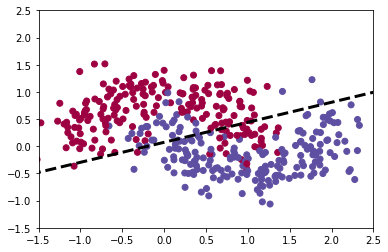

In [7]:
plot_decision_boundry(log_reg, X, Y)

In [8]:
predictions = log_reg.predict(X.T)
accuracy = np.count_nonzero(predictions == Y) / m * 100
print(f"Accuracy of logistic regression: {accuracy} % (percentage of correctly labelled datapoints)")

Accuracy of logistic regression: 84.5 % (percentage of correctly labelled datapoints)


In [9]:
def layer_sizes(X, Y):
    n_x = X.shape[0]
    n_h = 4
    n_y = Y.shape[0]

    return (n_x, n_h, n_y)

In [10]:
n_x, n_h, n_y = layer_sizes(X, Y)
print(f"The size of the input layer is: n_x = {n_x}")
print(f"The size of the hidden layer is: n_h = {n_h}")
print(f"The size of the output layer is: n_y = {n_y}")

The size of the input layer is: n_x = 2
The size of the hidden layer is: n_h = 4
The size of the output layer is: n_y = 1


In [11]:
def sigmoid(X):
    return 1 / (1 + np.exp(-X))

In [12]:
class Parameters(TypedDict):
    W1: np.ndarray
    b1: np.ndarray
    W2: np.ndarray
    b2: np.ndarray

def initialize_parameters(n_x: int, n_h: int, n_y: int) -> Parameters:
    W1 = rng.standard_normal((n_h, n_x)) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = rng.standard_normal((n_y, n_h)) * 0.01
    b2 = np.zeros((n_y, 1))

    parameters = dict(W1 = W1, b1 = b1, W2 = W2, b2 = b2)

    return parameters

In [13]:
parameters = initialize_parameters(n_x, n_h, n_y)

In [14]:
class Cache(TypedDict):
    Z1: np.ndarray
    A1: np.ndarray
    Z2: np.ndarray
    A2: np.ndarray

def forward_propagation(X, parameters: Parameters) -> Cache:
    W1, b1 = parameters["W1"], parameters["b1"]
    W2, b2 = parameters["W2"], parameters["b2"]

    assert X.shape == (2, m)

    Z1 = W1 @ X + b1
    A1 = np.tanh(Z1)

    Z2 = W2 @ A1 + b2
    A2 = sigmoid(Z2)

    cache = dict(Z1 = Z1, A1 = A1, Z2 = Z2, A2 = A2)
    
    return cache

In [15]:
cache = forward_propagation(X, parameters)

In [16]:
def compute_cost(A2, Y):
    assert A2.shape == Y.shape

    cost = -1/m * np.sum(Y * np.log(A2) + (1 - Y) * np.log(1 - A2))

    return cost

In [17]:
cost = compute_cost(cache["A2"], Y)
print(cost)

0.6931634483897118


In [18]:
class Grads(TypedDict):
    dW1: np.ndarray
    db1: np.ndarray
    dW2: np.ndarray
    db2: np.ndarray

def backward_propagation(parameters, cache, X, Y) -> Grads:
    W1, W2 = parameters["W1"], parameters["W2"]
    A1, A2 = cache["A1"], cache["A2"]

    dZ2 = A2 - Y
    dW2 = 1/m * dZ2 @ A1.T
    db2 = 1/m * np.sum(dZ2, axis = 1, keepdims=True)

    dZ1 = W2.T @ dZ2 * (1 - A1 ** 2)
    dW1 = 1/m * dZ1 @ X.T
    db1 = 1/m * np.sum(dZ1, axis=1, keepdims=True)

    grads = dict(dW1 = dW1, db1 = db1, dW2 = dW2, db2 = db2)

    return grads

In [19]:
grads = backward_propagation(parameters, cache, X, Y)
print(grads)

{'dW1': array([[ 4.16220438e-05, -3.06836160e-05],
       [ 2.11317027e-03, -1.55797579e-03],
       [-2.17684471e-03,  1.60592624e-03],
       [-1.92696311e-03,  1.42060247e-03]]), 'db1': array([[ 8.03033114e-09],
       [ 3.41775372e-07],
       [ 1.77292112e-07],
       [-3.26425049e-07]]), 'dW2': array([[-0.00265436, -0.00014129,  0.00245405, -0.00089433]]), 'db2': array([[-4.16417513e-05]])}


In [20]:
def update_parameters(parameters, grads, learning_rate = 1.2) -> Parameters:
    W1, W2 = parameters["W1"], parameters["W2"]
    b1, b2 = parameters["b1"], parameters["b2"]

    dW1, dW2 = grads["dW1"], grads["dW2"]
    db1, db2 = grads["db1"], grads["db2"]

    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    parameters = dict(W1 = W1, b1 = b1, W2 = W2, b2 = b2)

    return parameters

In [21]:
parameters = update_parameters(parameters, grads)

In [22]:
def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False): 
    parameters = initialize_parameters(n_x, 4, n_y)

    for i in range(0, num_iterations): 
        cache = forward_propagation(X, parameters)
        A2 = cache["A2"]
        cost = compute_cost(A2, Y)
        grads = backward_propagation(parameters, cache, X, Y)
        parameters = update_parameters(parameters, grads)

        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

In [23]:
parameters = nn_model(X, Y, 4, num_iterations=10000, print_cost=True)
print(parameters)

Cost after iteration 0: 0.693133
Cost after iteration 1000: 0.178517
Cost after iteration 2000: 0.157088
Cost after iteration 3000: 0.153079
Cost after iteration 4000: 0.151481
Cost after iteration 5000: 0.150663
Cost after iteration 6000: 0.150213
Cost after iteration 7000: 0.149946
Cost after iteration 8000: 0.149775
Cost after iteration 9000: 0.149656
{'W1': array([[-1.93870791, -0.04502325],
       [-6.69362968, -1.21650479],
       [ 4.44196476,  0.49428331],
       [-1.35361868, -3.15587207]]), 'b1': array([[-0.13346366],
       [ 2.77938766],
       [-6.75119291],
       [ 1.69258134]]), 'W2': array([[-9.12598908,  5.58706485,  7.66499701,  4.24501273]]), 'b2': array([[2.59549824]])}


In [24]:
def predict(parameters, X_new):
    cache = forward_propagation(X_new, parameters)
    A2 = cache["A2"]
    
    predictions = A2 > 0.5
    
    return predictions

In [25]:
predictions = predict(parameters, X)
accuracy = np.count_nonzero(predictions == Y) / m * 100
print(f"Accuracy of neurel network: {accuracy} % (percentage of correctly labelled datapoints)")

Accuracy of neurel network: 94.0 % (percentage of correctly labelled datapoints)
